<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq


from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [4]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

  Preparing metadata (setup.py) ... done
  Created wheel for trueskill: filename=trueskill-0.4.5-py3-none-any.whl size=18048 sha256=7feda0bb341d2317226336da006c7ad92aebdc34751e17087b061febe5b405cc
  Stored in directory: /root/.cache/pip/wheels/b9/4f/29/c79f0a2956775524c7a23638ac2b6fbb516c680f8e5eed9b53
Successfully built trueskill


In [5]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')


# Import user defined python functions
import model_evaluation_functions
import ratings_functions
importlib.reload(model_evaluation_functions)
importlib.reload(ratings_functions)

from ratings_functions import *
from model_evaluation_functions import *


Mounted at /content/drive


In [6]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [7]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [8]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    select * from preparation_layer.view_fa_cup_scores order by sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)

# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)
#def create_all_ranks_df():
 #   global all_ranks_df
  #  all_ranks_df = pd.DataFrame(columns=['team_no'])

#create_all_ranks_df()
#display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)



,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,475990,2010-01-19,58,Accrington Stanley,4,1,54,Gillingham,3,0,58,54,1,0,1,54,1
301,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
302,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
303,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


,team_no,fold_number


,metric_id,metric


Fold 1/5
Train data size: 244
Test data size: 61
basic_position
<function basic_position_ratings at 0x7b6fdae29fc0>
[(1, 1.0), (2, 0.5), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.14285714285714285), (8, 0.125), (9, 0.1111111111111111), (10, 0.1), (11, 0.09090909090909091), (12, 0.08333333333333333), (13, 0.07692307692307693), (14, 0.07142857142857142), (15, 0.06666666666666667), (16, 0.0625), (17, 0.058823529411764705), (18, 0.05555555555555555), (19, 0.05263157894736842), (20, 0.05), (21, 0.047619047619047616), (22, 0.045454545454545456), (23, 0.043478260869565216), (24, 0.041666666666666664), (25, 0.04), (26, 0.038461538461538464), (27, 0.037037037037037035), (28, 0.03571428571428571), (29, 0.034482758620689655), (30, 0.03333333333333333), (31, 0.03225806451612903), (32, 0.03125), (33, 0.030303030303030304), (34, 0.029411764705882353), (35, 0.02857142857142857), (36, 0.027777777777777776), (37, 0.02702702702702703), (38, 0.02631578947368421), (39, 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1,1428623,27,2,1,1,0.037037,1.000000,1,1,0,0,0.723715
2,basic_position,1,957292,2,1,22,2,0.500000,0.045455,2,2,0,0,0.611719
3,basic_position,1,846113,2,1,42,2,0.500000,0.023810,2,2,0,0,0.616848
4,basic_position,1,192160,2,1,41,2,0.500000,0.024390,2,2,0,0,0.616711
5,basic_position,1,883278,3,1,33,2,0.333333,0.030303,3,3,0,0,0.575183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,basic_position,5,1349449,61,5,46,3,0.016393,0.021739,46,46,0,0,0.501336
302,basic_position,5,472572,47,3,64,6,0.021277,0.015625,47,47,0,0,0.501413
303,basic_position,5,846034,47,3,63,5,0.021277,0.015873,47,47,0,0,0.501351
304,basic_position,5,475990,58,4,54,3,0.017241,0.018519,54,58,1,0,0.500319


,accuracy
1,0.737705
2,0.737705
3,0.737705
4,0.721311
5,0.721311


,ratings_model,fold_number,team_no,rating,rank
320,basic_position,0,1,1.000000,1
0,basic_position,1,1,1.000000,1
4,basic_position,2,1,1.000000,1
2,basic_position,3,1,1.000000,1
1,basic_position,4,1,1.000000,1
...,...,...,...,...,...
317,basic_position,1,64,0.015625,64
316,basic_position,2,64,0.015625,64
318,basic_position,3,64,0.015625,64
315,basic_position,4,64,0.015625,64


Mean Upset Accuracy: 0.7311
Standard Deviation of Upset Accuracy: 0.0080
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
305 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,1
...,...,...,...
379,64,1,64
380,64,2,64
381,64,3,64
382,64,4,64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-validation Accuracy,0.731
1,2,Cross-validation Standard Deviation,0.008
2,3,Overall Accuracy,0.731
3,4,Confusion Matrix - True Negative (Class 0),223.000
4,5,Confusion Matrix - False Positive (Class 1),0.000
5,6,Confusion Matrix - False Negative (Class 0),82.000
6,7,Confusion Matrix - True Positive (Class 1),0.000
7,8,Precision (Class 0),0.731
8,9,Recall (Class 0),1.000
9,10,F1-score (Class 0),0.845


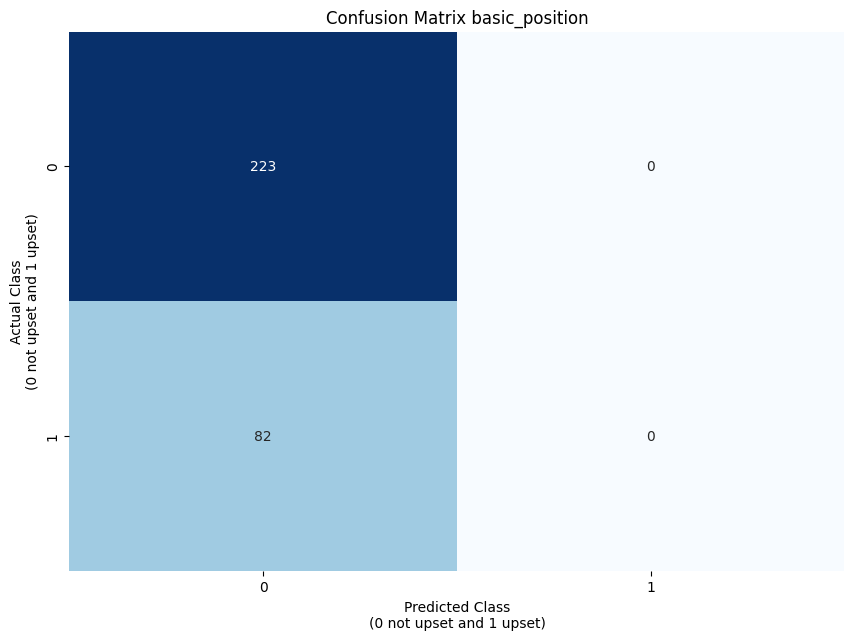

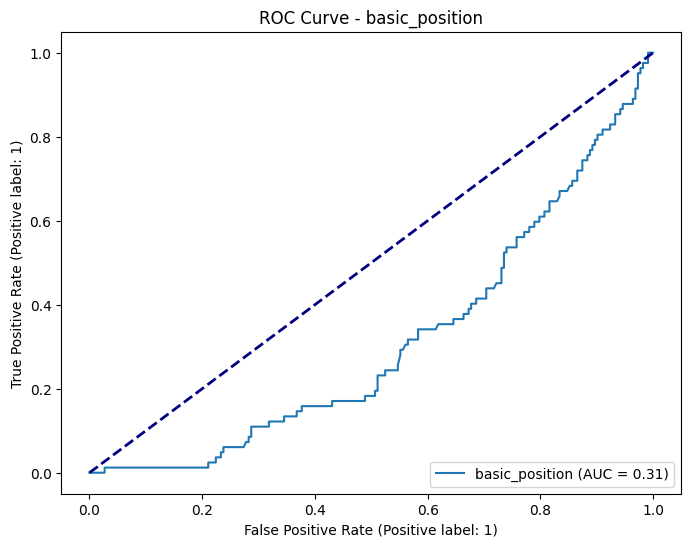

In [9]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation

results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)


# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



In [ ]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = massey_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



In [ ]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = keener_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



In [ ]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


In [ ]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    #credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    rankings = {
        'basic_position': all_ranks_df['basic_position'].tolist(),
        'massey': all_ranks_df['massey'].tolist(),
        'colley': all_ranks_df['colley'].tolist(),
        'keener': all_ranks_df['keener'].tolist(),
        'trueskill': all_ranks_df['trueskill'].tolist()
    }

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['borda_count'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


In [ ]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')